In [1]:
from coal_mapper import *
import kmapper as km
import sklearn
import seaborn as sns

In [2]:
all = pd.read_excel("dfc2.xlsx")

In [ ]:
#map with 2 lenses

import plotly.graph_objs as go
from ipywidgets import (HBox, VBox)

from sklearn import ensemble, cluster

df = all
df=df[df['GENNTAN']>658653]


X = (df[['GENNTAN', 'PLSO2AN', 'PlantAge', 'post2004RetrofitCosts', 'CO2limitsOppose']])
y = np.array(df["scenario"])

df3 = df[['GENNTAN', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'decom', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC']]

colors = df3
labels = mapper_labels(df['label'])

# Create a custom 1-D lens with Isolation Forest
model = ensemble.IsolationForest(random_state=1729)
model.fit(X)
lens1 = model.decision_function(X).reshape((X.shape[0], 1))

# Create another 1-D lens with L2-norm
mapper = km.KeplerMapper(verbose=0)
lens2 = mapper.fit_transform(X, projection="l2norm")

# Combine lenses pairwise to get a 2-D lens i.e. [Isolation Forest, L^2-Norm] lens
lens = np.c_[lens1, lens2]

scaler = StandardScaler()
data = scaler.fit_transform(X)
projected_data = mapper.fit_transform(data, projection=sklearn.manifold.TSNE())

# Define the simplicial complex
scomplex = mapper.map(#lens,
                      X,
                      cover=km.Cover(n_cubes=15,
                                     perc_overlap=0.53),
                      clusterer=sklearn.cluster.KMeans(n_clusters=3, random_state=3471))

In [ ]:
from kmapper.plotlyviz import *

color_values = lens [:,0] - lens[:,0].min()
my_colorscale = my_colorscale
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex,
                                                                 color_values,
                                                                 color_function_name='Distance to x-min',
                                                                 colorscale=my_colorscale)

for node in kmgraph['nodes']:
    node['custom_tooltips'] = y[scomplex['nodes'][node['name']]]

In [ ]:
bgcolor = 'rgba(10,10,10, 0.9)'
y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

In [ ]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale,
                                 factor_size=2.5, edge_linewidth=0.5)
layout = plot_layout(title='Topological network representing the<br>  breast cancer  dataset',
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph,
                             fw_graph,
                             ctooltips=True, # ctooltips = True, because we assigned a label to each
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor,
                             member_textbox_width=600)

#Update the fw_graph colorbar, setting its title:

fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

In [ ]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

In [ ]:
dashboard

In [ ]:
breastc_dict = {1: 'scn1', 2: 'scn2', 3:'scn3', 4:'scn4'}
tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips

new_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y[scomplex['nodes'][node['name']]]
    member_labels = [breastc_dict[id] for id in member_label_ids]
    label_type, label_counts = np.unique(member_labels, return_counts=True)

    n_members = label_counts.sum()
    if label_type.shape[0] == 1:
        if label_type[0] == 'benign':
            new_color.append(0)
        else:
            new_color.append(1)
    else:
        new_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+

    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) # append  how many benign/malign
                                                                                 # members exist in each node

fwn_graph = go.FigureWidget(fw_graph) # copy the initial FigureWidget

with fwn_graph.batch_update(): # make updates for the new figure
    fwn_graph.data[1].text = tooltips # add the new tooltips
    fwn_graph.data[1].marker.colorbar.x = -0.14 # place toolbar at the figure left side
    fwn_graph.layout.width = 550 # change the figure size in order to plot two "parallel" copies
    fwn_graph.layout.height = 550
    fwn_graph.layout.margin.r = 45 # decrease the right margin from 60px (default val) to 45 pixels

fw1 = go.FigureWidget(fwn_graph) # define a new figure from  the fwn_graph that will be colored by the new color function
with fw1.batch_update():
    fw1.data[1].marker.color = new_color # update node colors
    fw1.data[0].line.color = 'rgb(125,125,125)' # update the graph edge color
    fw1.layout.plot_bgcolor = 'rgb(240,240,240)'
    fw1.layout.annotations = None # remove the mapper_summary from the second plot
    fw1.data[1].marker.showscale = False # remove the colorbar
    fw1.layout.title = "Nodes are colored according to the proportion<br> of malignant members"

In [ ]:
HBox([fwn_graph, fw1])

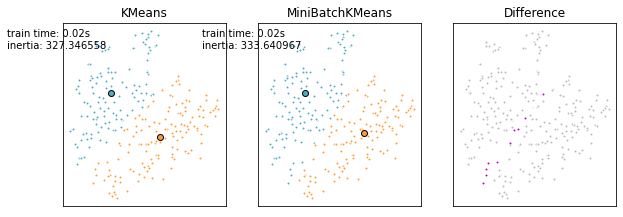

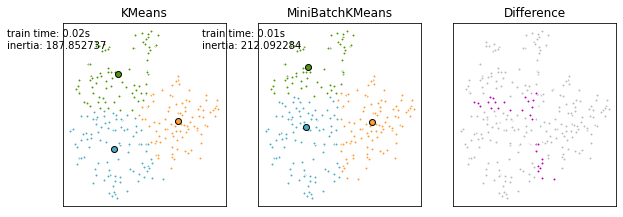

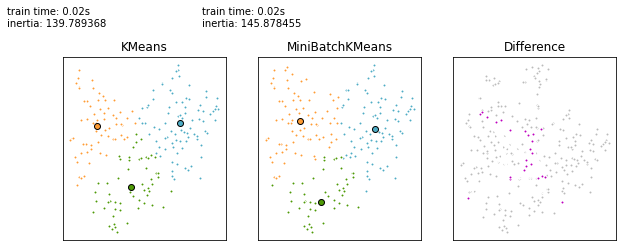

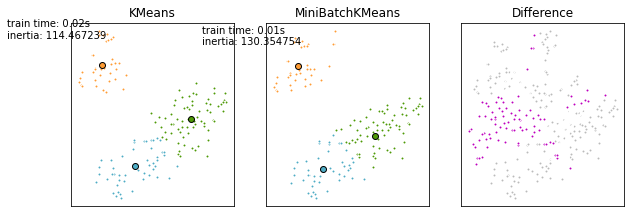

In [317]:
view_kmeans(projected_data, 2)
view_kmeans(projected_data, 3)
view_kmeans(projected_data, 4)
view_kmeans(projected_data, 5)

In [4]:
my_colorscale = [[0.0, '#001219'],
             [0.1, '#005f73'],
             [0.2, '#0a9396'],
             [0.3, '#94d2bd'],
             [0.4, '#e9d8a6'],
             [0.5, '#ee9b00'],
             [0.6, '#ca6702'],
             [0.7, '#bb3e03'],
             [0.8, '#ae2012'],
             [0.9, '#9b2226'],
             [1.0, '#a50026']]  

### Create Simplicial Complex of all 264 Coal Powerplants

In [5]:
df = all
df=df.fillna(0)
df2 = (df[['GENNTAN', 'CAPFAC', 'PLSO2AN', 'post2004RetrofitCosts', 'PlantAge', 'CO2limitsOppose', 'affectedDAC', 'pop_score']])
df3 = df[['GENNTAN', 'air_metric', 'PLCO2AN', 'PLNOXAN', 'PLSO2AN', 'decom', 'CarbonIntensity', 'StateMineEmployment', 'CO2limitsOppose', 'PlantAge', 'post2004RetrofitCosts', 'post2004Retrofit', 'retrofitLevelized', 'GENYRRET', 'RenewableReplacement', 'CAPFAC', 'PartiallyRetired', 'pop_metric', 'dac_metric', 'total population (ACS2018)', 'affectedDAC', 'scenario', 'pop_score', 'percDAC_score']]

mapper = km.KeplerMapper(verbose=0)
scaler = StandardScaler()
data = scaler.fit_transform(df2)
projected_data = mapper.fit_transform(data, projection=sklearn.manifold.TSNE())


In [6]:
#15 0.5 3 – good groupings

cubes = 10
overlap = 0.5
clusters = 4

colors = df3
labels = mapper_labels(df['label'])

graph_new = mapper.map(
    projected_data,
    remove_duplicate_nodes=True,
    cover=km.Cover(n_cubes=cubes, perc_overlap=overlap),
    clusterer=sklearn.cluster.KMeans(n_clusters=clusters)
    )

mapper.visualize(
    graph_new,
    path_html="lens_choice2.html",
    title="US Coal Plant Set (" +str(cubes)+ " cubes at " +str(overlap*100) + "% overlap) with Plant Labels",
    custom_tooltips=labels,
    color_values = colors,
    colorscale=my_colorscale,
    color_function_name=list(df3.columns),
    node_color_function=['mean', 'median', 'max', 'min', 'std'],
    include_searchbar = True, 
    #include_intersection_selector= True
)

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>US Coal Plant Set (10 cubes at 50.0% overlap) with Plant Labels | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: upper

In [66]:
all.groupby('scenario')[['PM_emissions', 'PLSO2AN', 'PLNOXAN', 'PLCO2AN']].median()

PM_emissions  PLSO2AN   PLNOXAN       PLCO2AN
scenario                                               
1            15.151726   230.70   177.579  1.783461e+05
2           120.187948  2014.70  1686.787  2.710618e+06
3           243.397849   871.70  2242.151  4.721902e+06
4           795.716963  3714.25  4581.190  7.183206e+06

phase creation helper:

In [ ]:
dfList = [Adf, Bdf, Cdf, Ddf, Edf]
phase = pd.DataFrame()
for i in range(0,len(dfList)):
    phase = pd.concat([phase, dfList[i]])


In [ ]:
heatmap = phase.groupby('phase')[['post2004RetrofitCosts', 'GENNTAN', 'PLSO2AN', 'PlantAge', 'CO2limitsOppose', 'air_metric', 'affectedDAC']].mean()

In [ ]:
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(heatmap.to_numpy())
df_scaled = pd.DataFrame(df_scaled, 
    columns=['post2004RetrofitCosts', 'GENNTAN', 'PLSO2AN', 'PlantAge', 'CO2limitsOppose', 'air_metric', 'affectedDAC'],
    index = ['A', 'B', 'C', 'D', 'E'])

sns.heatmap(df_scaled, annot=True, cmap = 'RdYlGn_r')

In [143]:
test = all
test['sum'] = np.log(all['PM_emissions']+all['PLNOXAN']+all['PLSO2AN'])
test['air_level'] = (test['sum'])/(test['sum'].mean())*100
test['pop'] = np.log(all['total population (ACS2018)'])
test['pop_level'] = (test['pop'])/(test['pop'].mean())*100

test['impact_score'] = test['pop_level']*test['air_level']

test['Percent DAC'] = test['National percentile for Demographic Index']

/Users/gathrid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

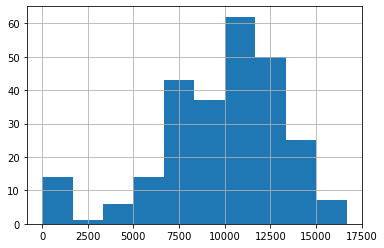

In [144]:
test['impact_score'].hist()

In [153]:
import plotly.express as px



fig = px.scatter(data_frame=test, 
y = test['pop_level'], 
x = test['air_level'], 
color = test['Percent DAC'],
size=test['GENNTAN'], 
hover_name = test['label'],
#facet_col="scenario",
marginal_x="histogram", marginal_y="histogram",

)

fig.add_hline(y=100)
fig.add_vline(x = 100)


fig.update_traces(marker=dict(line=dict(color='black', width = 0.2)))

fig.update_layout(width=1100, height = 700)

## HELPER METHODS: Find all powerplants in a node cluster

In [ ]:
####HELPER
def getClusterData(cube_cluster_ID:str):
    return mapper.data_from_cluster_id(cube_cluster_ID, graph_new, labels)

####HELPER
def getIndicieFromLabel(list:str, df:str):
    '''Get the indicies of cluster ID labels from the original data frame
    list: list of mapper cluster ID labels
    df: original DF used for mapper'''

    indexList = []
    for i in list:
        index = 0
        for x in df.label:
            index = index+1
            if i == x:
                indexList.append(index-1)
                break
    return indexList

####HELPER
def indexList_toData (indexList, mapperdf):
    df = mapperdf
    '''Get the full row of data corresponding to the index of mapper Cluster IDs
    indexList: output of the getIndicieFromLabel function
    df: oringinal DF used for mapper'''
    newdf = df.loc[[indexList[0]]]
    for i in range(1, len(indexList)):
        newdf = pd.concat([df.loc[[indexList[i]]], newdf])
    return newdf

def getNodeIDList(nodeIDLabels):
    '''Insert a list of mapper NodeID labels. 
    ex. nodeIDLabels = ['node17_cluster2', 'node22_cluster5']

    Returns a list of NodeID data labels (coal plant 'label') from the given nodeID labels
    '''
    outL = []
    for i in nodeIDLabels:
        outL = np.concatenate((outL, getClusterData(i)))
    return outL

def focusMapper(outL, mapperdf):
    '''returns a coal_mapper formatted dataframe from a nodeID list: outL
    
    outL: a list of NodeID cluster labels, output from getNodeIDList function
    mapperdf: the original mapperDF used
    '''
    indexL = getIndicieFromLabel(outL, mapperdf)
    datadf = indexList_toData(indexL, mapperdf)
    return datadf

In [310]:
## THE SETUP
uneditedLinks = list(graph_new['links'].keys())
uneditedLinked = list(graph_new['links'].values())
links = uneditedLinks
linked = uneditedLinked

## in Links
def getChildren(id:int):
    return linked[id]

def linksIndex(id:str):
    return links.index(id)

## not in Links
def parentsList(id:str):
    def linkedIndexes(id:str):
        list1 =  [[ind,ind2] for ind,i in enumerate(linked) for ind2, y in enumerate(i) if y == id]
        outputList = []
        for i in list1:
            outputList.append(i[0])
        return outputList

    indexList = linkedIndexes(id)
    list22 = []
    for i in indexList:
        list22.append(links[i])
    return list22

def childList(id:str):
    index = linksIndex(id)
    internalList = []
    internalList.extend(getChildren(index))
    return internalList

## cube_cluster either in links, linked, or both. Hence, run both methods

def rec_links(id:str):
    l2 = []
    if id in l2:
        print("extra")
    elif id in links:
        list21 = childList(id)
        for i in list21:
            if i not in l2:
                l2.append(i)
            l2.extend(rec_links(i))
    return l2

def rec_linked(id:str):
    l2=[]
    if id in l2:
        print("extra")
    elif len(parentsList(id)) > 0:
        l2.append(id)
        pList = parentsList(id)
        for i in pList:
            if i not in l2:
                l2.append(i)
            l2.extend(rec_links(i))
    return l2

def remDuplicates(out:list):
    newL = []
    for i in out:
        if i not in newL:
            newL.append(i)
    return newL

#final helper:

def getConnections(id:str):
    l1 = rec_links(id)
    l2 = rec_linked(id)
    l1.extend(l2)
    outtahere = remDuplicates(l1)
    return outtahere

In [318]:
## ## MAINS: Find all powerplants in a node cluster

In [321]:
#generate list of node_cluster_IDs from link simplicicy
def getLinkedList(cube_cluster:str):
    out = getConnections(cube_cluster)
    out2 = []
    for i in out:
        out2.extend(getConnections(i))
    return remDuplicates(out2)

#convert list of node_cluster_ID to df of Powerplants"
def focusedDF(id:list):
    outL2 = getNodeIDList(id)
    exp2df = focusMapper(outL2, all)
    return exp2df.drop_duplicates(subset=['ORISPL']).reset_index()


In [328]:
trialdf = focusedDF(getLinkedList('cube86_cluster2'))
trialdf.groupby('scenario')[['GENNTAN', 'PartiallyRetired', 'pop_score', 'affectedDAC']].mean()

GENNTAN  PartiallyRetired     pop_score   affectedDAC
scenario                                                            
1         1.922839e+05          0.571429  11472.951470  51441.098571
2         1.287942e+06          0.400000  12859.619685  18339.486000

In [320]:
graph_new['simplices']

[['cube1_cluster0-cube2_cluster0'],
 ['cube1_cluster1'],
 ['cube1_cluster2'],
 ['cube1_cluster3'],
 ['cube2_cluster1-cube3_cluster0'],
 ['cube2_cluster2-cube10_cluster1-cube11_cluster2'],
 ['cube2_cluster3-cube3_cluster3'],
 ['cube3_cluster1-cube4_cluster0'],
 ['cube3_cluster2-cube4_cluster2-cube12_cluster2-cube13_cluster2'],
 ['cube4_cluster1-cube5_cluster2-cube13_cluster0'],
 ['cube4_cluster3-cube5_cluster3'],
 ['cube5_cluster0-cube6_cluster0-cube15_cluster3'],
 ['cube5_cluster1'],
 ['cube6_cluster1'],
 ['cube6_cluster2'],
 ['cube6_cluster3'],
 ['cube7_cluster0-cube16_cluster3-cube17_cluster1'],
 ['cube7_cluster1'],
 ['cube7_cluster2'],
 ['cube7_cluster3'],
 ['cube10_cluster0'],
 ['cube10_cluster2'],
 ['cube10_cluster3-cube21_cluster3'],
 ['cube11_cluster0'],
 ['cube11_cluster1-cube12_cluster3-cube21_cluster2-cube22_cluster3'],
 ['cube11_cluster3-cube12_cluster1'],
 ['cube12_cluster0-cube13_cluster1'],
 ['cube13_cluster3'],
 ['cube14_cluster0'],
 ['cube14_cluster1'],
 ['cube14_cluste